<a href="https://colab.research.google.com/github/Jsakkos/mf-lon-cyanos-rvae/blob/main/notebooks/cells_CB_rVAE_paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook analyzes the data for set of carboxysomes.

The masks were generated with Cellpose (https://www.cellpose.org/) for the 4, 8, 24, 48, and 72 hours. Those masks were saved in google drive and are downloaded here as the array "subimg". This array is then divided into subimg_1, subimg_2...,subimg_10, where subimg_i, i=1,5 corresponds to the data for the control samples and subimg_i, i=6,10 corresponds to data for the induced samples.

A trained rotationally invariant variational autoencoder, rVAE, is also downloaded here. 

The plots are then generated using the trained rVAE and the subimg_i.

Authors:

Miguel Fuentes-Cabrera, Center for Nanophase Materials Sciences, Oak Ridge National Laboratory

Jonathan Sakkos, Michigan State University


In [288]:
# Import required packages
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import napari
from aicsimageio import AICSImage
from skimage.measure import label, regionprops, regionprops_table
from skimage.segmentation import clear_border
from skimage.color import label2rgb


In [134]:
# Some helper functions to cut windows of the same size and containing only invididual organelles.
def make_square(img,box_size):
  y = (box_size - img.shape[0])
  if y%2==0:
    y1=y2=y/2
  else:
    y1 = np.ceil(y/2)
    y2 = y - y1
  x = (box_size - img.shape[1])
  if x%2==0:
    x1=x2=x/2
  else:
    x1 = np.ceil(x/2)
    x2 = x - x1
  
  return np.pad(img,((int(y1),int(y2)),(int(x1),int(x2))),mode='constant',constant_values=0)
def normalize_01(inp: np.ndarray):
    """
    normalize image range from 0 to 1
    """
    inp_out = (inp - np.min(inp)) / np.ptp(inp)
    return inp_out

def rotate_and_pad_img(sample,pixels,box_size,rotate=False):
    """
    Function to crop, rotate, and pad a labelled section of a segmented image
    Args:
      sample (label)
      Sample from labelled image

      pixels (array)
      image array, H x W, single-channel
      
      box_size (int)
      Size of final square image dimension
    Returns square-padded image array
    """
    angle = np.degrees(sample.orientation)
    length = sample.major_axis_length
    width = sample.minor_axis_length
    #target_channel = pixels[sample.slice[0].start:sample.slice[0].stop, sample.slice[1].start:sample.slice[1].stop]
    #target_channel = target_channel * sample.filled_image
    return make_square(sample.filled_image,box_size)

def mask2stack(ccm_mask,cell_mask=None,window_size=40,rotate=False):
  """
  Function to ingest cell mask and carboxysome mask or pixel intensity and output an array of padded submasks
  Args:
  cell_mask (labelled image)
  
  ccm_mask (labelled image or pixel intensity array)

  window_size (int)
  Size of padded image
  """

  if cell_mask.size > 0:
    labelled_image = label(cell_mask)
    feature_table = regionprops(labelled_image)
    CellSize_label = []
        # remove debris
    for i in feature_table:
        if (i.area) > 40 and (i.major_axis_length/i.minor_axis_length) > 2:
                CellSize_label.append(i.label)
    subimgs = []
    for i in np.argsort(CellSize_label):
        sample = feature_table[CellSize_label[i]-1]
        cell = rotate_and_pad_img(sample,cell_mask,window_size,rotate)
        ccm = rotate_and_pad_img(sample,ccm_mask,window_size,rotate)
        #ccm = np.ones(ccm.shape) * (ccm >0.01)
        subimgs.append(ccm)
  else:
    labelled_image = label(ccm_mask)
    feature_table = regionprops(labelled_image)
    subimgs = [make_square(np.ones(sample.filled_image.shape) * sample.filled_image,window_size) for sample in feature_table]
  return np.stack(subimgs,axis=0)

In [24]:
def blended_img(viewer):
    import napari
    import numpy as np
    
    blended = np.zeros(viewer.layers[0].data.shape + (4,))
    for layer in viewer.layers:
        # normalize data by clims
        normalized_data = (layer.data - layer.contrast_limits[0]) / (
        layer.contrast_limits[1] - layer.contrast_limits[0]
    )
        colormapped_data = layer.colormap.map(normalized_data.flatten())
        colormapped_data = colormapped_data.reshape(normalized_data.shape + (4,))

        blended = blended + colormapped_data
    
    blended[..., 3] = 1 # set alpha channel to 1

    return np.squeeze(blended)

In [362]:
img = AICSImage(r"D:\mf-lon-cyanos-rvae\data\Control\48\Control-02.czi")
cell_mask = np.load(r"D:\mf-lon-cyanos-rvae\data\Control\48\Control-02_cell.npy")
ccm_mask = np.load(r"D:\mf-lon-cyanos-rvae\data\Control\48\Control-02_ccm.npy")
#viewer = napari.Viewer()  # how do I use napari-aicsimageio instead?
#layer = viewer.add_image(img.data)
viewer = napari.view_image(img.data, channel_axis=1, name=["ccm", "dsred","bf"], colormap=["green", "magenta",'gray'])
viewer.layers.pop(2)
blended = blended_img(viewer)

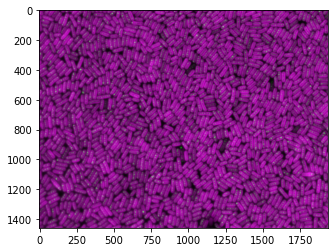

In [26]:
plt.imshow(np.squeeze(blended))

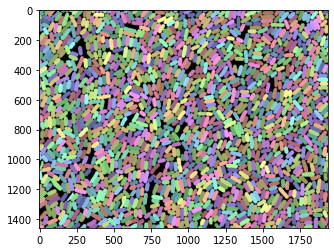

In [356]:
import colorsys
n =500
colors = [np.array(colorsys.hsv_to_rgb(np.random.uniform(0,360),0.4,np.random.uniform(0.6,1))) for i in range(n)]
image_label_overlay = label2rgb(label(cell_mask), bg_label=0,colors=colors)
plt.imshow(image_label_overlay)

help(label2rgb)

In [357]:
viewer = napari.view_image(img.data, channel_axis=1, name=["ccm", "dsred","bf"], colormap=["green", "magenta",'gray'])
viewer.layers.pop(2)
cell_labels = viewer.add_labels(cell_mask, name='cells')
viewer.layers.pop(1)
viewer.layers.pop(0)
#cell_blended = blended_img(viewer)


<Image layer 'ccm' at 0x22bfac38af0>

C:\Users\Jonathan\AppData\Local\Temp/ipykernel_15992/3798381707.py:119: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, ax = plt.subplots()


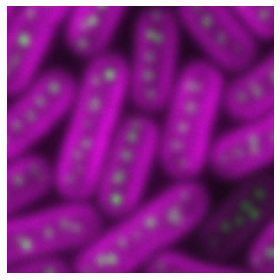

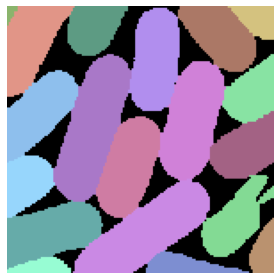

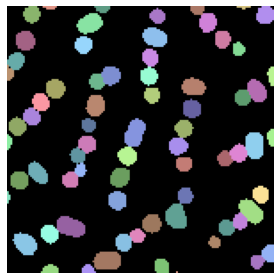

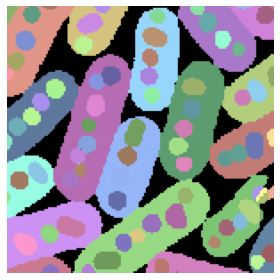

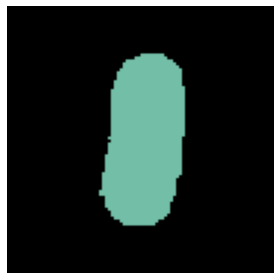

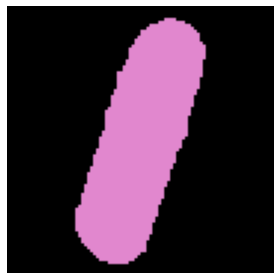

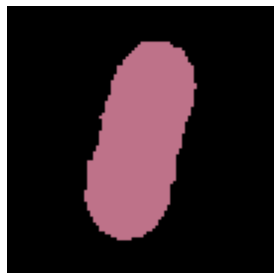

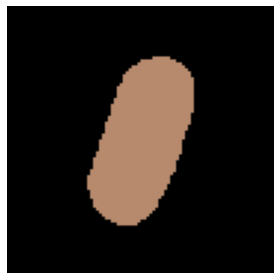

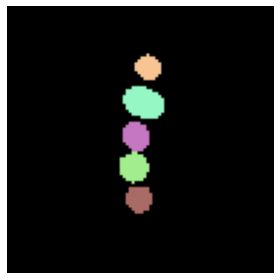

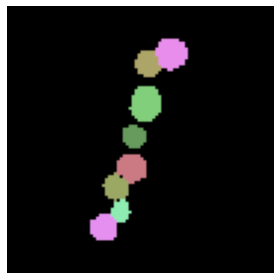

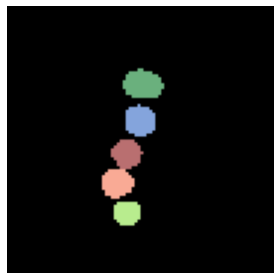

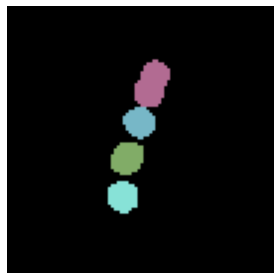

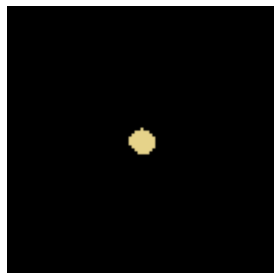

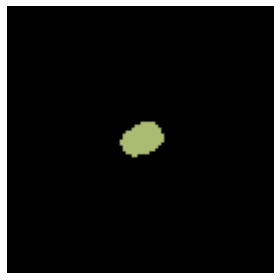

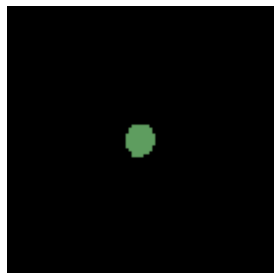

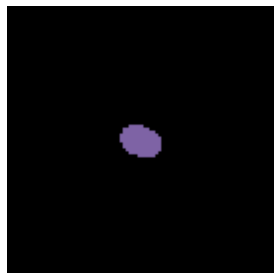

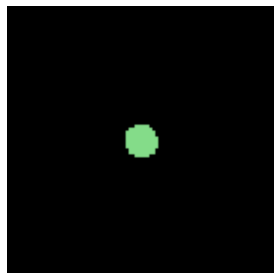

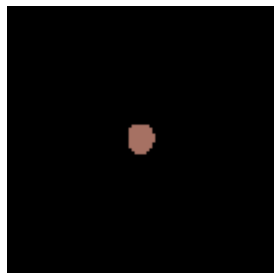

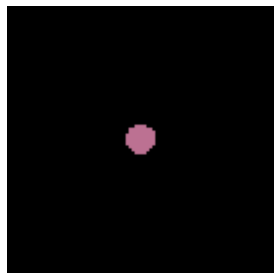

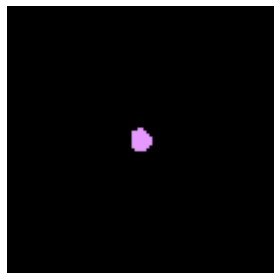

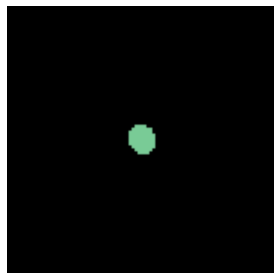

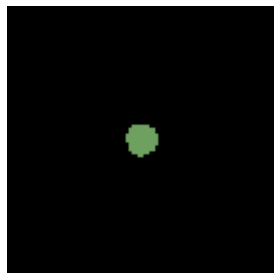

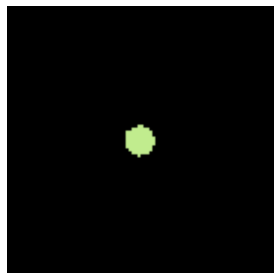

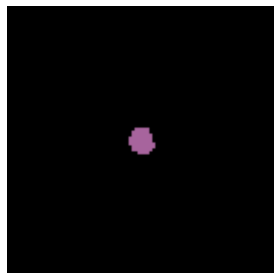

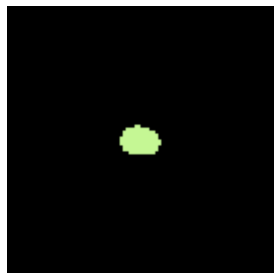

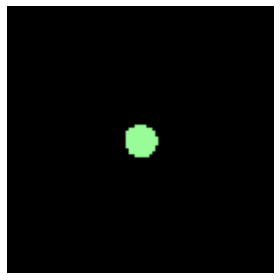

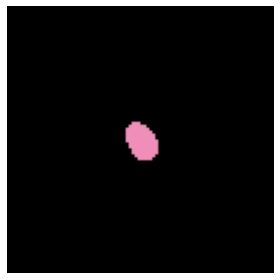

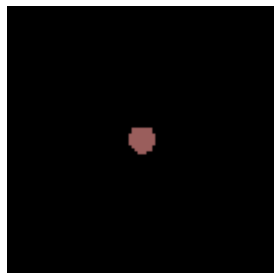

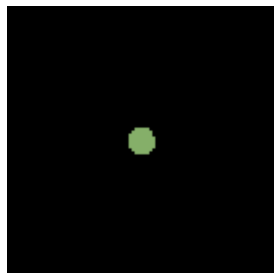

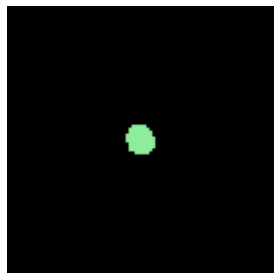

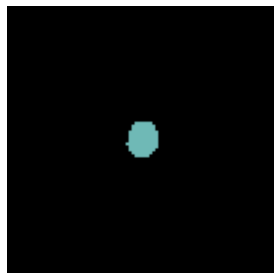

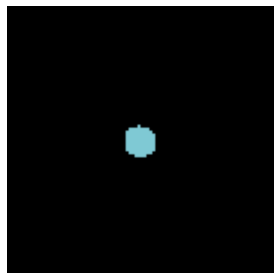

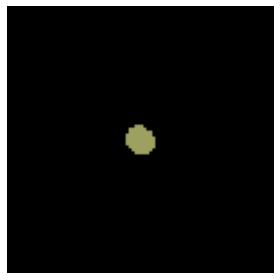

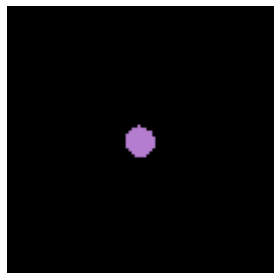

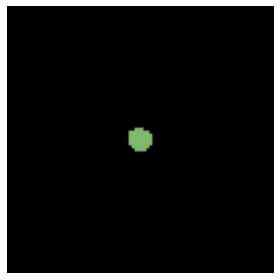

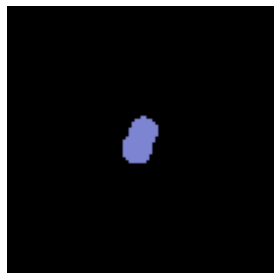

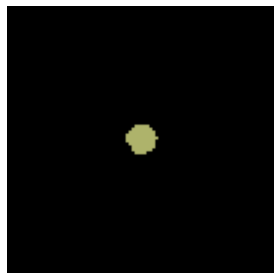

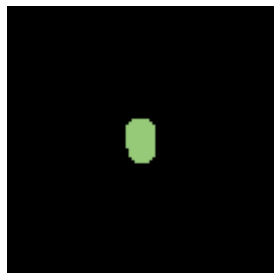

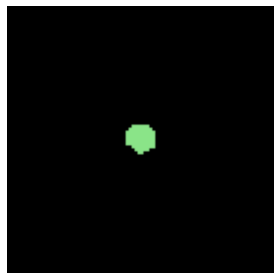

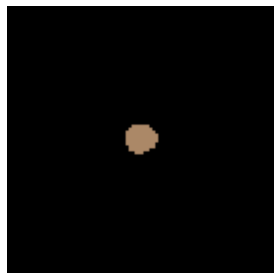

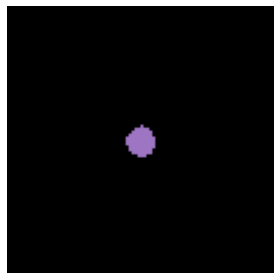

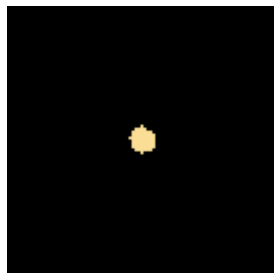

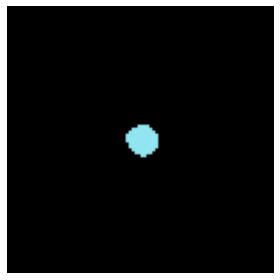

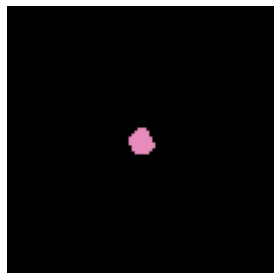

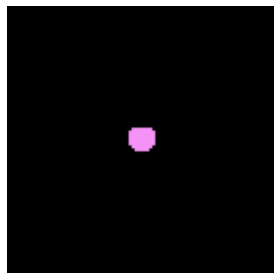

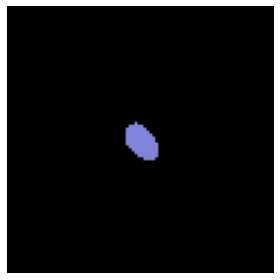

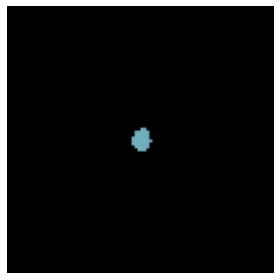

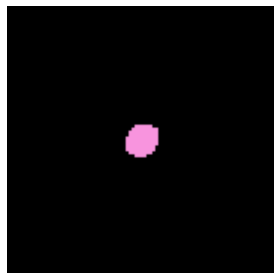

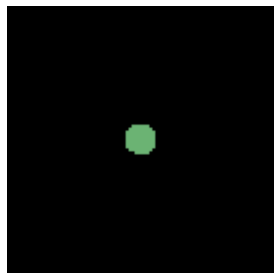

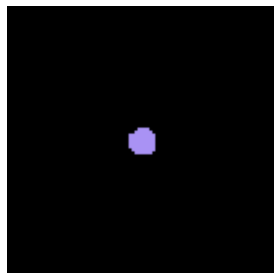

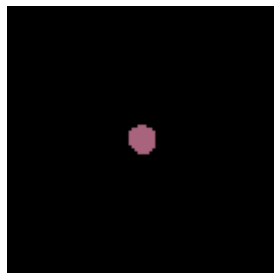

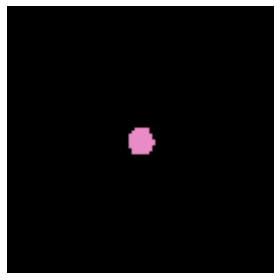

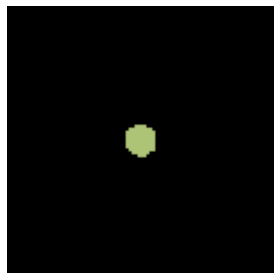

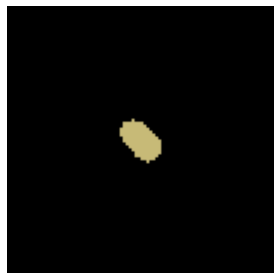

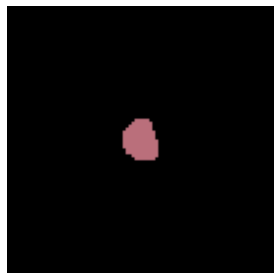

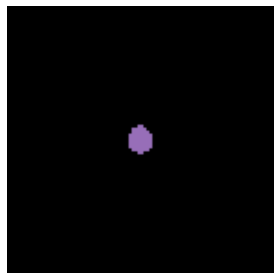

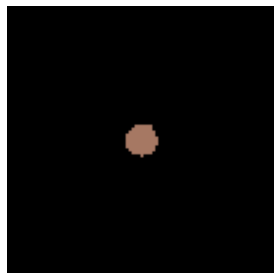

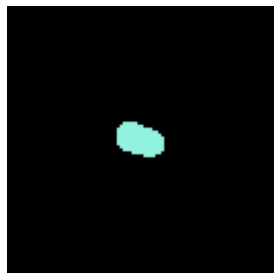

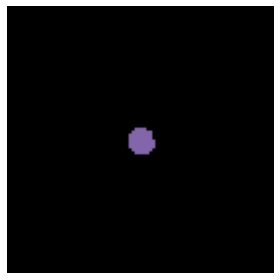

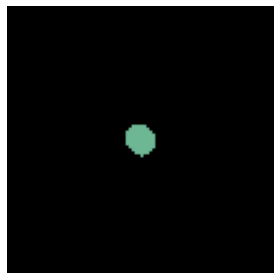

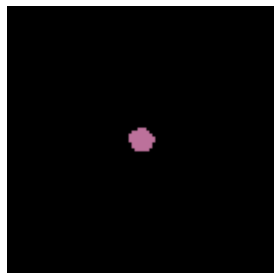

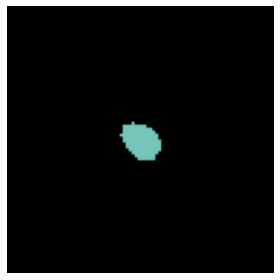

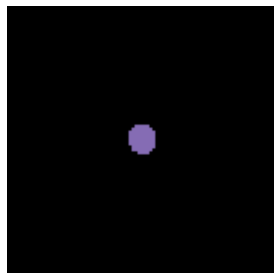

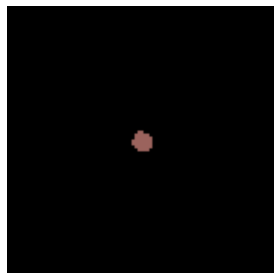

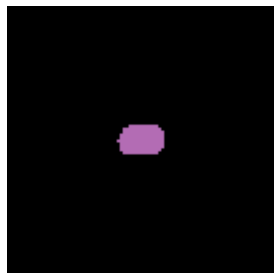

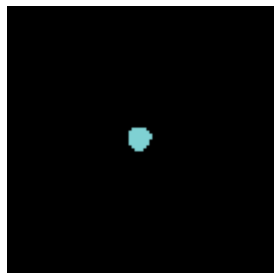

In [369]:

window = 150
x=np.random.randint(window,blended.shape[0]-window)
y=np.random.randint(window,blended.shape[1]-window)
x1=int(x-window/2)
x2=int(x+window/2)
y1=int(y-window/2)
y2=int(y+window/2)
crop=blended[x1:x2,y1:y2,:]
cell_crop = cell_mask[x1:x2,y1:y2]
ccm_crop = ccm_mask[x1:x2,y1:y2]
window_size=90

def seg(cell_crop,ccm_crop,window_size):

    labelled_image = label(cell_crop)
    cleared = clear_border(labelled_image)
    feature_table = regionprops(cleared)
    whole_cell = []
    ccm_cell = []
    for sample in feature_table:
        cell=make_square(np.ones(sample.filled_image.shape) * sample.filled_image,window_size)
        target_channel = ccm_crop[sample.slice[0].start:sample.slice[0].stop, sample.slice[1].start:sample.slice[1].stop]
        target_channel = target_channel * sample.filled_image
        ccm=make_square(target_channel,window_size)
        whole_cell.append(cell)
        ccm_cell.append(ccm)


    labelled_image = label(ccm_crop)
    cleared = clear_border(labelled_image)
    feature_table = regionprops(cleared)

    ccm_ind = []
    for sample in feature_table:
        target_channel = ccm_crop[sample.slice[0].start:sample.slice[0].stop, sample.slice[1].start:sample.slice[1].stop]
        target_channel = target_channel * sample.filled_image
        ccm=make_square(target_channel,window_size)
        ccm_ind.append(ccm)
    return whole_cell, ccm_cell, ccm_ind

cells,whole_ccm,ccm_ind = seg(cell_crop,ccm_crop,window_size)
f, ax = plt.subplots()
ax.imshow(crop)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_axis_off()
f.tight_layout()
f.savefig(f'../figures/cropped.pdf',bbox_inches='tight')
f, ax = plt.subplots()
ax.imshow(label2rgb(label(cell_crop), bg_label=0,colors=colors))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_axis_off()
f.tight_layout()
f.savefig(f'../figures/cells_cropped.pdf',bbox_inches='tight')
f, ax = plt.subplots()
ax.imshow(label2rgb(label(ccm_crop), bg_label=0,colors=colors))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_axis_off()
f.tight_layout()
f.savefig(f'../figures/ccm_cropped.pdf',bbox_inches='tight')
f, ax = plt.subplots()
ax.imshow(label2rgb(label(ccm_crop+cell_crop), bg_label=0,colors=colors))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_axis_off()
f.tight_layout()
f.savefig(f'../figures/combo_cropped.pdf',bbox_inches='tight')





""" f,axes = plt.subplots(ncols=4,nrows=len(whole_ccm)+1,figsize=(10,15))
axes[0,0].imshow(crop)
axes[0,1].imshow(cell_crop)
cleared =clear_border(cell_crop)



for ax,cell in zip(axes[:,1].ravel(),cells):
    ax.imshow(cell)
for ax,ccms in zip(axes[:,2].ravel(),whole_ccm):
    ax.imshow(ccms)
for i in range(len(axes[:,3].ravel())):
    axes[i,3].imshow(ccm_ind[i])
axes[0,2].imshow(ccm_crop)
for ax in axes.ravel():
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_axis_off() """

    # save cell image files
for i,cell in enumerate(cells):
    f, ax = plt.subplots()
    ax.imshow(label2rgb(label(cell), bg_label=0,colors=[np.array(colorsys.hsv_to_rgb(np.random.uniform(0,360),0.4,np.random.uniform(0.6,1))) for i in range(50)]))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_axis_off()
    f.tight_layout()
    f.savefig(f'../figures/cell{i}.pdf',bbox_inches='tight')
for i,cell in enumerate(whole_ccm):
    f, ax = plt.subplots()
    ax.imshow(label2rgb(label(cell), bg_label=0,colors=[np.array(colorsys.hsv_to_rgb(np.random.uniform(0,360),0.4,np.random.uniform(0.6,1))) for i in range(50)]))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_axis_off()
    f.tight_layout()
    f.savefig(f'../figures/whole_cell_ccm{i}.pdf',bbox_inches='tight')
for i,cell in enumerate(ccm_ind):
    f, ax = plt.subplots()
    ax.imshow(label2rgb(label(cell), bg_label=0,colors=[np.array(colorsys.hsv_to_rgb(np.random.uniform(0,360),0.4,np.random.uniform(0.6,1))) for i in range(50)]))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_axis_off()
    f.tight_layout()
    f.savefig(f'../figures/indiv_ccm{i}.pdf',bbox_inches='tight')